In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#Importaremos para optimización
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

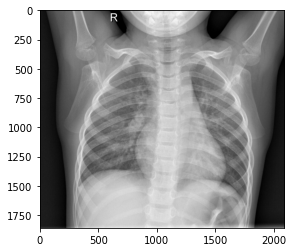

In [3]:
img= load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(img)

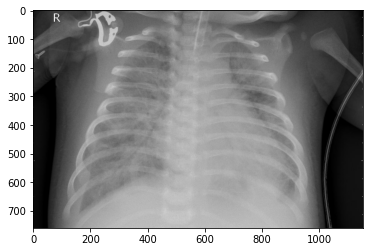

In [4]:
img= load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')
plt.imshow(img)

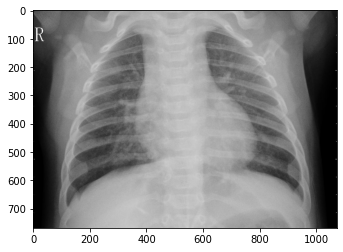

In [5]:
img= load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
plt.imshow(img)

In [6]:
img=img_to_array(img)

In [7]:
train_path = "../input/chest-xray-pneumonia/chest_xray/train"
val_path = "../input/chest-xray-pneumonia/chest_xray/val"

In [8]:
datagen= ImageDataGenerator(rotation_range=25,
                   width_shift_range=0.2,
                   height_shift_range=0.2,
                   zoom_range = 0.8,
                   horizontal_flip = True,
                   fill_mode = 'nearest',
                   brightness_range= [0.3,1.8],
                   rescale=1./255,
                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = datagen.flow_from_directory(
train_path,
#target_size = (150,150),
batch_size = 3,
class_mode = 'binary',
color_mode ="grayscale",
subset = 'training')

validation_generator = datagen.flow_from_directory(train_path,
                                 #target_size=(150,150),
                                 batch_size=3,
                                 class_mode='binary',
                                 color_mode ="grayscale",
                                 subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [10]:
validation_generator.image_shape

(256, 256, 1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

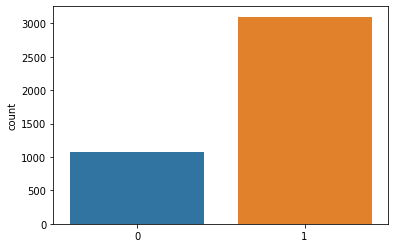

In [11]:
import seaborn as sns
sns.countplot(train_generator.classes)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

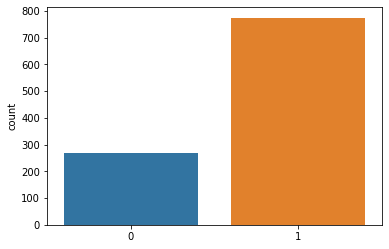

In [12]:
sns.countplot(validation_generator.classes)

In [13]:
from sklearn.utils.class_weight import compute_sample_weight
train_weights=compute_sample_weight(class_weight='balanced', y=train_generator.classes)
print(train_weights)


[1.944548   1.944548   1.944548   ... 0.67306452 0.67306452 0.67306452]


Modeling

In [14]:
base_filter= 32
w_regularizer = 1e-4

model = Sequential()
#CONV1
model.add(Conv2D(base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer),
                 input_shape = (256,256,1)))

model.add(Activation('relu'))


#CONV2
model.add(Conv2D(2*base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization()) #normalizacion para optimizar
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#CONV3
model.add(Conv2D(4*base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))


#CONV4
model.add(Conv2D(4*base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization()) #normalizacion para optimizar
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#CONV5
model.add(Conv2D(6*base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

##CONV6
model.add(Conv2D(6*base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu')) #Ahora le pondremos maxpooling para reducir la complejidad

#CONV7
model.add(Conv2D(8*base_filter, (3,3), padding='same',
                 kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization()) #normalizacion para optimizar
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## Clasificacion - Flatten

model.add(Flatten())
#Usaremos ahora una capa densa para clasificar, con softmax porque son multiples
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()





2022-10-23 18:57:13.283837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 18:57:13.375118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 18:57:13.375969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 18:57:13.377875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0

node zero
2022-10-23 18:57:15.445939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 18:57:15.446783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 18:57:15.447470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 18:57:15.448067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
model.compile(loss='binary_crossentropy', optimizer = 'adam',
              metrics=['accuracy']
              )

In [ ]:
#Early Stoppings
early = EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = ModelCheckpoint('pneumonia_model.hdf5',monitor='val_accuracy', verbose= 1, save_best_only=True)

hist = model.fit_generator(train_generator, callbacks=[checkpoint,early],
          epochs = 60,#steps_per_epoch=2000//32,
          verbose=2,#validation_steps= 1000//32,
          validation_data=validation_generator, shuffle=True)

Epoch 1/60


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-23 18:57:16.142130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-23 18:57:18.143332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1391/1391 - 128s - loss: 10.6643 - accuracy: 0.6319 - val_loss: 1.3425 - val_accuracy: 0.6884

Epoch 00001: val_accuracy improved from -inf to 0.68840, saving model to pneumonia_model.hdf5
Epoch 2/60
1391/1391 - 89s - loss: 1.2880 - accuracy: 0.6552 - val_loss: 1.3379 - val_accuracy: 0.5427

Epoch 00002: val_accuracy did not improve from 0.68840
Epoch 3/60
1391/1391 - 88s - loss: 0.7922 - accuracy: 0.7024 - val_loss: 0.6963 - val_accuracy: 0.6807

Epoch 00003: val_accuracy did not improve from 0.68840
Epoch 4/60
1391/1391 - 88s - loss: 0.7004 - accuracy: 0.7148 - val_loss: 0.6285 - val_accuracy: 0.7498

Epoch 00004: val_accuracy improved from 0.68840 to 0.74976, saving model to pneumonia_model.hdf5
Epoch 5/60
1391/1391 - 87s - loss: 0.6388 - accuracy: 0.7342 - val_loss: 0.8217 - val_accuracy: 0.6596

Epoch 00005: val_accuracy did not improve from 0.74976
Epoch 6/60
1391/1391 - 87s - loss: 0.7284 - accuracy: 0.7031 - val_loss: 0.6265 - val_accuracy: 0.7258

Epoch 00006: val_accuracy did

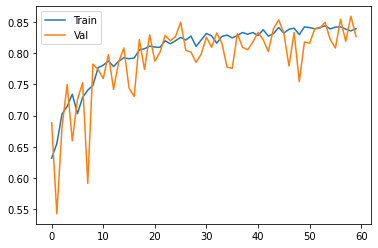

In [22]:
plt.plot(hist.history['accuracy'], label = 'Train')
plt.plot(hist.history['val_accuracy'], label = 'Val')
plt.legend()
plt.show()

In [23]:
model.save('model.h5')

In [28]:
model2 = model
model2.load_weights('./pneumonia_model.hdf5')

In [34]:
test_path = "../input/chest-xray-pneumonia/chest_xray/test"
test_generator = test_datagen.flow_from_directory(test_path,
                                 #target_size=(150,150),
                                 batch_size=3,
                                 class_mode='binary',color_mode ="grayscale",
                                 shuffle=True
                                 )

Found 624 images belonging to 2 classes.


In [35]:
model2.evaluate(test_generator)

208/208 [==============================] - 6s 28ms/step - loss: 0.4904 - accuracy: 0.7788


[0.4903525710105896, 0.7788461446762085]

In [ ]:
preds = model2.predict(test_generator)

In [46]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_generator.labels, np.round(preds.reshape(624,),0) )

array([[111, 123],
       [185, 205]])

In [44]:
preds.reshape(624,)

array([0.95299834, 0.98149073, 0.02700142, 0.1603933 , 0.19719826,
       0.8586591 , 0.2818073 , 0.942721  , 0.9520071 , 0.16862944,
       0.65722036, 0.64339316, 0.35013467, 0.08167859, 0.98430204,
       0.78176224, 0.8621855 , 0.20059682, 0.13302065, 0.84197515,
       0.583869  , 0.965193  , 0.10390349, 0.9789873 , 0.05461402,
       0.30119514, 0.7534612 , 0.3238198 , 0.96367854, 0.06924885,
       0.8112108 , 0.17658612, 0.7567071 , 0.06863505, 0.93382543,
       0.8107957 , 0.978403  , 0.3077548 , 0.45260015, 0.46370634,
       0.972462  , 0.98147476, 0.79214615, 0.9632554 , 0.8262429 ,
       0.47586045, 0.08315258, 0.37837374, 0.29007354, 0.5454487 ,
       0.96869284, 0.93302464, 0.4594233 , 0.94332606, 0.5966142 ,
       0.36858344, 0.90386313, 0.24392307, 0.4582264 , 0.18239124,
       0.19420613, 0.94091475, 0.41216558, 0.25683215, 0.9571585 ,
       0.93999845, 0.8477074 , 0.5244555 , 0.92892057, 0.96432567,
       0.9405409 , 0.40443492, 0.5970438 , 0.29767004, 0.89541

In [43]:
test_generator.labels.shape

(624,)